# Import libraries and data

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import f_oneway
from sklearn.decomposition import PCA

# Times font for plotting
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

font = FontProperties(family='Times New Roman')

In [36]:
path = 'SegmentData.xlsx'

df = pd.read_excel(path)

df.head()

,age,gender,income,kids,ownHome,subscribe,Segment
0,42,Male,64437,1,ownNo,subNo,Suburb mix
1,38,Female,65608,2,ownNo,subNo,Suburb mix
2,39,Female,45426,1,ownNo,subNo,Suburb mix
3,40,Female,63066,0,ownNo,subNo,Suburb mix
4,32,Female,45927,5,ownYes,subNo,Suburb mix


# Initial Data processing

We note that 3 of the variables above (gender, ownHome, subscribe (and segment)) are not numerical, but rather categorical. However, they can easily be transformed to numerical values using pandas map function.

In [37]:
def preprocess_data(df):
    df_processed = df.copy()

    # Handle categorical variables
    df_processed['gender'] = df_processed['gender'].map({'Male': 0, 'Female': 1})
    df_processed['ownHome'] = df_processed['ownHome'].map({'ownNo': 0, 'ownYes': 1})
    df_processed['subscribe'] = df_processed['subscribe'].map({'subNo': 0, 'subYes': 1})
    #df_processed['Segment'] = df_processed['Segment'].map({'Suburb mix': 1, 'Urban hip': 2, 'Travelers': 3, 'Moving up': 4})

    # remove target variable
    df_processed = df_processed.drop(columns=['Segment'])

    return df_processed

In [38]:
df_processed = preprocess_data(df)

df_processed.head()

,age,gender,income,kids,ownHome,subscribe
0,42,0,64437,1,0,0
1,38,1,65608,2,0,0
2,39,1,45426,1,0,0
3,40,1,63066,0,0,0
4,32,1,45927,5,1,0


# Question 1. K-means clustering

In [39]:
# we make a copy of the processed data set that is used throughout Q1
df_q1 = df_processed.copy()

### (i) Exploratory Data Analysis (EDA)

##### Summary statistics for all variables 

Here, we use the processed df to be able to get statistics for the categorical features as well.

In [40]:
df_q1.describe()

,age,gender,income,kids,ownHome,subscribe
count,300.000000,300.000000,300.000000,300.000000,300.00000,300.000000
mean,40.556667,0.496667,52071.226667,1.283333,0.46000,0.116667
std,12.683178,0.500824,19724.666164,1.362317,0.49923,0.321559
min,18.000000,0.000000,10557.000000,0.000000,0.00000,0.000000
25%,33.000000,0.000000,41275.250000,0.000000,0.00000,0.000000
50%,39.000000,0.000000,53186.500000,1.000000,0.00000,0.000000
75%,48.000000,1.000000,64236.000000,2.000000,1.00000,0.000000
max,73.000000,1.000000,114615.000000,7.000000,1.00000,1.000000


##### Histogram for each variable

For simplicity, we can use to original dataset to get att the correct variable names.

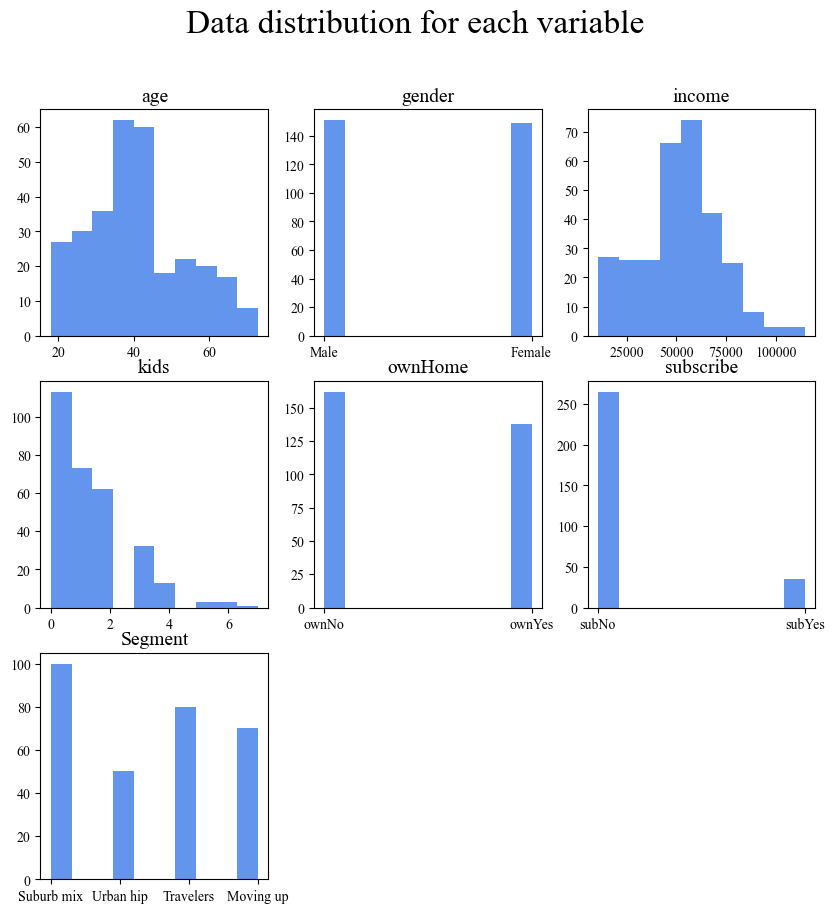

In [41]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))

axes = axes.ravel()

for n, variable in enumerate(df.columns):
    axes[n].hist(df[variable], color='cornflowerblue')
    axes[n].set_title(variable, fontproperties=font, fontsize=14)

    #set font for tick marks
    for xlabel in (axes[n].get_xticklabels()):
        xlabel.set_fontproperties(font)

    for ylabel in (axes[n].get_yticklabels()):
        ylabel.set_fontproperties(font)

#delete unused subplots
fig.delaxes(axes[7])
fig.delaxes(axes[8])

fig.suptitle('Data distribution for each variable',fontproperties=font, fontsize=24)

plt.show()

##### Correlation matrix

Text(0.5, 0.98, 'Correlation heatmap')

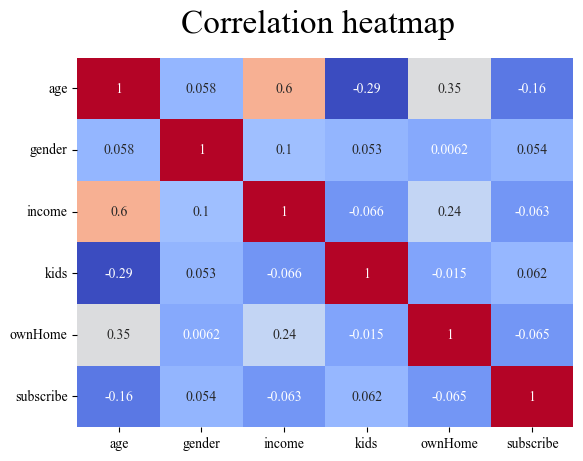

In [42]:
# select numeric variables and create correlation matrix
corr = df_processed.corr()

fig, axes = plt.subplots()
sns.heatmap(corr, annot=True, cmap=plt.get_cmap('coolwarm'), cbar=False, ax=axes)
axes.set_yticklabels(axes.get_yticklabels(), rotation='horizontal')

fig.suptitle('Correlation heatmap', fontproperties=font, fontsize=24)

### (ii) Apply the K-means clustering algorithm

In [43]:
# Select features for clustering (excluding Segment)
X = df_q1.copy()

# Standardize numerical features (age, income, kids) since K-means is sensitive to scale
numerical_features = ['age', 'income', 'kids']
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# Apply K-means clustering with K=4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=50)
kmeans.fit(X)

KMeans(n_clusters=4, n_init=50, random_state=42)

In [44]:
# Get cluster assignments
labels = kmeans.labels_

# Add cluster labels to the processed data
df_q1['cluster'] = labels

df_q1.head()

,age,gender,income,kids,ownHome,subscribe,cluster
0,42,0,64437,1,0,0,2
1,38,1,65608,2,0,0,1
2,39,1,45426,1,0,0,2
3,40,1,63066,0,0,0,2
4,32,1,45927,5,1,0,1


##### Reporting the sizes of each cluster 

In [45]:
# Compute cluster sizes
cluster_sizes = df_q1['cluster'].value_counts().sort_index()

cluster_sizes.to_frame()

,count
cluster,
0,51
1,97
2,89
3,63


##### Reporting the mean values for all features in each cluster

In [46]:
# Compute mean values for each feature in each cluster
# Use processed data for interpretability (numerical in original scale, binary as proportions)
cluster_means = df_q1.groupby('cluster').mean()
cluster_means.round(3)

,age,gender,income,kids,ownHome,subscribe
cluster,,,,,,
0,23.118,0.314,21654.706,1.137,0.176,0.157
1,37.680,0.619,54592.959,2.804,0.474,0.124
2,40.685,0.494,52160.989,0.483,0.416,0.157
3,58.921,0.460,72684.651,0.190,0.730,0.016


### (iii) Visualizing the cluster solution

Plot the cluster solution with respect to the variables Age and Income. Include the cluster centroids in the plot.

In [47]:
# Get cluster centroids
centroids = kmeans.cluster_centers_

# Inverse transform centroids to original scale for age and income
centroids_original_scale = scaler.inverse_transform(centroids[:, [0, 2, 3]])  # Select age, income, kids
centroids_age_income = centroids_original_scale[:, [0, 1]]  # Only age and income for plotting

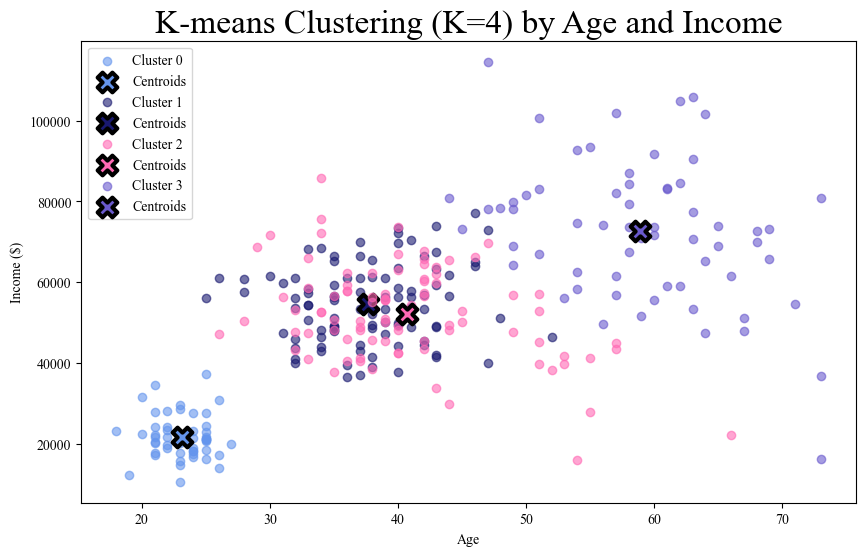

In [48]:
plt.figure(figsize=(10, 6))
colors = ['cornflowerblue', 'midnightblue', 'hotpink', 'slateblue']
cluster_labels = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']

# Plot data points for each cluster 
# Plot centroids
for i in range(4):
    cluster_data = df_q1[df_q1['cluster'] == i]
    plt.scatter(cluster_data['age'], cluster_data['income'], c=colors[i], label=cluster_labels[i], alpha=0.6)
    plt.scatter(centroids_age_income[i, 0], centroids_age_income[i, 1], c=colors[i], edgecolors='black', marker='X', s=200, linewidths=3, label='Centroids')


# Add labels and title
plt.xlabel('Age')
plt.ylabel('Income ($)')
plt.title('K-means Clustering (K=4) by Age and Income', fontsize=24)
plt.legend()


### (iv) Continuing visualization of the cluster solution

##### Boxplots for Income across different clusters

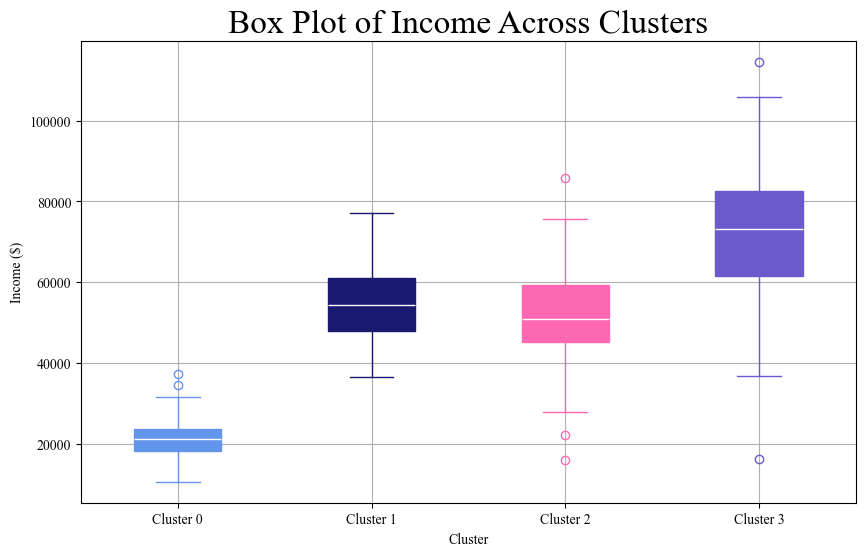

In [49]:
colors = ['cornflowerblue', 'midnightblue', 'hotpink', 'slateblue']
cluster_labels = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']
income_data = [df_q1[df_q1['cluster'] == i]['income'] for i in range(4)]

plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(income_data, 
                      tick_labels=cluster_labels, 
                      patch_artist=True,
                      medianprops=dict(color='white'))

plt.title('Box Plot of Income Across Clusters', fontsize=24)
plt.xlabel('Cluster')
plt.ylabel('Income ($)')

for i, color in enumerate(colors):
    plt.setp(boxplot['boxes'][i], color=color)
    plt.setp(boxplot['fliers'][i], markeredgecolor=color)
    
plt.setp(boxplot['whiskers'][0], color='cornflowerblue')
plt.setp(boxplot['whiskers'][1], color='cornflowerblue')
plt.setp(boxplot['caps'][0], color='cornflowerblue')
plt.setp(boxplot['caps'][1], color='cornflowerblue')

plt.setp(boxplot['whiskers'][2], color='midnightblue')
plt.setp(boxplot['whiskers'][3], color='midnightblue')
plt.setp(boxplot['caps'][2], color='midnightblue')
plt.setp(boxplot['caps'][3], color='midnightblue')

plt.setp(boxplot['whiskers'][4], color='hotpink')
plt.setp(boxplot['whiskers'][5], color='hotpink')
plt.setp(boxplot['caps'][4], color='hotpink')
plt.setp(boxplot['caps'][5], color='hotpink')

plt.setp(boxplot['whiskers'][6], color='slateblue')
plt.setp(boxplot['whiskers'][7], color='slateblue')
plt.setp(boxplot['caps'][6], color='slateblue')
plt.setp(boxplot['caps'][7], color='slateblue')

plt.grid(True)
plt.show()

##### Box plots for age across different clusters

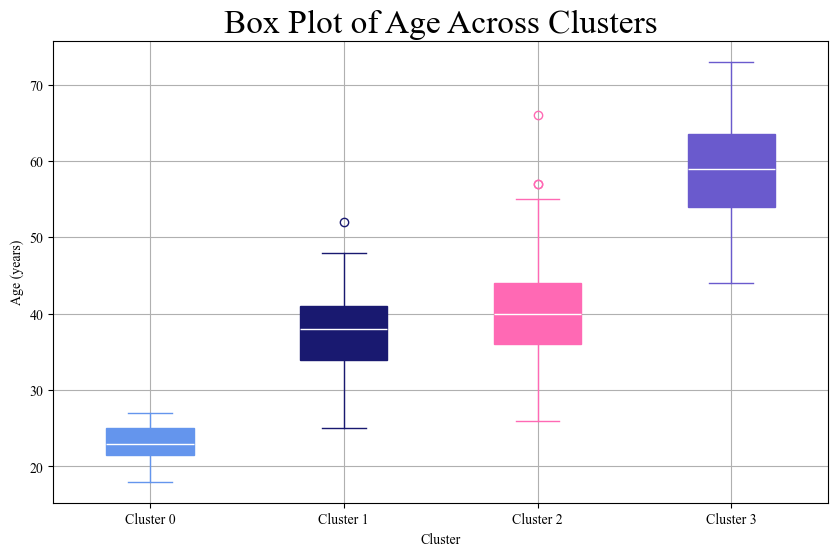

In [50]:
colors = ['cornflowerblue', 'midnightblue', 'hotpink', 'slateblue']
cluster_labels = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']
age_data = [df_q1[df_q1['cluster'] == i]['age'] for i in range(4)]

plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(age_data, 
                      tick_labels=cluster_labels, 
                      patch_artist=True,
                      medianprops=dict(color='white'))

plt.title('Box Plot of Age Across Clusters', fontsize=24)
plt.xlabel('Cluster')
plt.ylabel('Age (years)')

for i, color in enumerate(colors):
    plt.setp(boxplot['boxes'][i], color=color)
    plt.setp(boxplot['fliers'][i], markeredgecolor=color)
    
plt.setp(boxplot['whiskers'][0], color='cornflowerblue')
plt.setp(boxplot['whiskers'][1], color='cornflowerblue')
plt.setp(boxplot['caps'][0], color='cornflowerblue')
plt.setp(boxplot['caps'][1], color='cornflowerblue')

plt.setp(boxplot['whiskers'][2], color='midnightblue')
plt.setp(boxplot['whiskers'][3], color='midnightblue')
plt.setp(boxplot['caps'][2], color='midnightblue')
plt.setp(boxplot['caps'][3], color='midnightblue')

plt.setp(boxplot['whiskers'][4], color='hotpink')
plt.setp(boxplot['whiskers'][5], color='hotpink')
plt.setp(boxplot['caps'][4], color='hotpink')
plt.setp(boxplot['caps'][5], color='hotpink')

plt.setp(boxplot['whiskers'][6], color='slateblue')
plt.setp(boxplot['whiskers'][7], color='slateblue')
plt.setp(boxplot['caps'][6], color='slateblue')
plt.setp(boxplot['caps'][7], color='slateblue')


plt.grid(True)
plt.show()

### (v) Hypothesis testing

Test the hypothesis that the mean Income is the same for all clusters. Also, test the hypothesis that the mean Age is the same for all clusters. Hint: use ANOVA testing.

In [51]:
# Prepare data for ANOVA
cluster_groups = df_q1.groupby('cluster')

# Extract income and age for each cluster
income_by_cluster = [group['income'].values for name, group in cluster_groups]
age_by_cluster = [group['age'].values for name, group in cluster_groups]

In [52]:
# ANOVA Test for Income
income_anova = f_oneway(*income_by_cluster)
print('ANOVA Test for Income')
print(f"F-statistic: {income_anova.statistic:.4f}")
print(f"p-value: {income_anova.pvalue:.4f}")

if income_anova.pvalue < 0.05:
    print(f"With a p-value of {income_anova.pvalue:.4f} (< 0.05), we reject the null hypothesis.")
    print('Conclusion: There is significant evidence that mean income differs across clusters.')
else:
    print(f"With a p-value of {income_anova.pvalue:.4f} (>= 0.05), we fail to reject the null hypothesis.")
    print('Conclusion: There is insufficient evidence to suggest mean income differs across clusters.')

ANOVA Test for Income
F-statistic: 176.1917
p-value: 0.0000
With a p-value of 0.0000 (< 0.05), we reject the null hypothesis.
Conclusion: There is significant evidence that mean income differs across clusters.


In [53]:
# ANOVA Test for Age
age_anova = f_oneway(*age_by_cluster)
print("\n### ANOVA Test for Age")
print(f"F-statistic: {age_anova.statistic:.4f}")
print(f"p-value: {age_anova.pvalue:.4f}")

if age_anova.pvalue < 0.05:
    print(f"With a p-value of {age_anova.pvalue:.4f} (< 0.05), we reject the null hypothesis.")
    print("Conclusion: There is significant evidence that mean age differs across clusters.")
else:
    print(f"With a p-value of {age_anova.pvalue:.4f} (>= 0.05), we fail to reject the null hypothesis.")
    print("Conclusion: There is insufficient evidence to suggest mean age differs across clusters.")


### ANOVA Test for Age
F-statistic: 351.6646
p-value: 0.0000
With a p-value of 0.0000 (< 0.05), we reject the null hypothesis.
Conclusion: There is significant evidence that mean age differs across clusters.


### (vi) Determine the "optimal" number of clusters

The within-cluster sum of squares measures the total variance within each cluster. As K increases, WCSS decreases because more clusters fit the data more closely. The optimal K is where the WCSS reduction rate slows, forming an "elbow" shape on the plot.

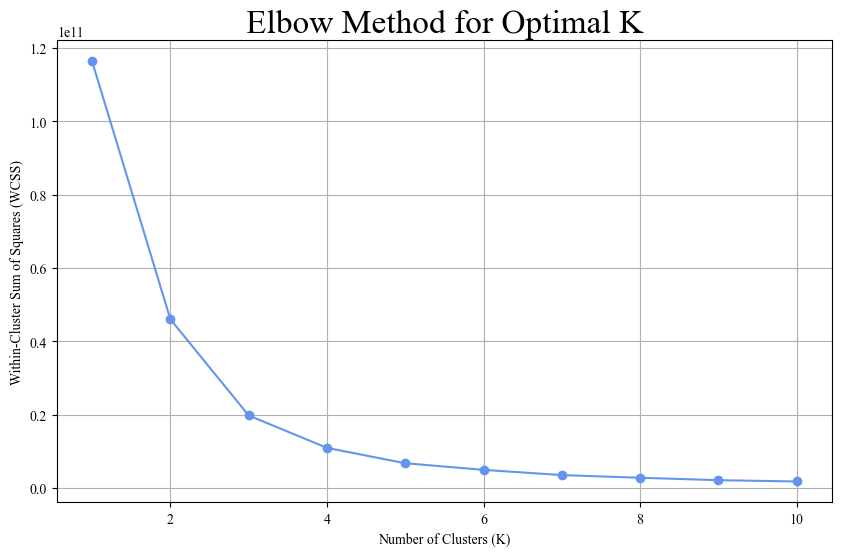

In [31]:
# Calculate WCSS for different K values
wcss = []
K_range = range(1, 11)  # Test K from 1 to 10
for k in K_range:
    kmeans_est = KMeans(n_clusters=k, random_state=42, n_init=50) # smoothness is heavinly dependent on n_init --> textbook said to use 20 or 50
    kmeans_est.fit(X)
    wcss.append(kmeans_est.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, wcss, marker='o', linestyle='-', color='cornflowerblue')
plt.title('Elbow Method for Optimal K', fontsize=24)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()

### (vii) How many of the respondents are correctly classified regarding their segmentation information?

In [22]:
# Add segment column to the current df we are working with
df_q1['Segment'] = df['Segment']

# Create contingency table (confusion matrix)
contingency_table = pd.crosstab(df_q1['Segment'], df_q1['cluster'], rownames=['Original Segment'], colnames=['K-means Cluster'])

contingency_table

K-means Cluster,0,1,2,3
Original Segment,,,,
Moving up,1,37,32,0
Suburb mix,0,60,37,3
Travelers,0,0,20,60
Urban hip,50,0,0,0


In [23]:
# Map clusters to original segments based on maximum overlap
cluster_mapping = {}
for cluster in contingency_table.columns:
    max_segment = contingency_table[cluster].idxmax()
    cluster_mapping[cluster] = max_segment

print("Cluster to Segment Mapping")
for cluster, segment in cluster_mapping.items():
    print(f"Cluster {cluster} mapped to '{segment}'")

Cluster to Segment Mapping
Cluster 0 mapped to 'Urban hip'
Cluster 1 mapped to 'Suburb mix'
Cluster 2 mapped to 'Suburb mix'
Cluster 3 mapped to 'Travelers'


In [24]:
# Calculate number of correct classifications
correct_classifications = 0
for cluster in contingency_table.columns:
    segment = cluster_mapping[cluster]
    correct_classifications += contingency_table.loc[segment, cluster]

total_points = len(df_q1)
accuracy = correct_classifications / total_points * 100

print("Classification Results")
print(f"Number of correctly classified points: {correct_classifications} out of {total_points}")
print(f"Accuracy: {accuracy:.2f}%")

Classification Results
Number of correctly classified points: 207 out of 300
Accuracy: 69.00%


##### Comparison with subsegments (using original data)

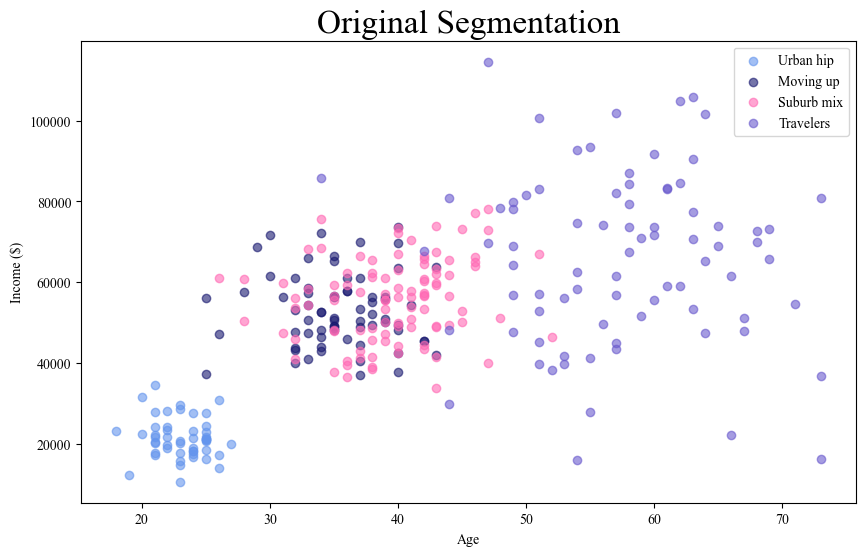

In [25]:
plt.figure(figsize=(10, 6))
colors = ['cornflowerblue', 'midnightblue', 'hotpink', 'slateblue']
segment_labels = ['Urban hip', 'Moving up', 'Suburb mix','Travelers',]

# Plot data points for each cluster
for i, segment in enumerate(segment_labels):
    segment_data = df[df['Segment'] == segment]
    plt.scatter(segment_data['age'], segment_data['income'], c=colors[i], label=segment_labels[i], alpha=0.6)

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Income ($)')
plt.title('Original Segmentation', fontsize=24)
plt.legend()

# Question 2: PCA

In [54]:
# we make a copy of the processed data set that is used throughout Q2
df_q2 = df_processed.copy()

# the following features are used (same as in Q1)
features = ['age', 'gender', 'income', 'kids', 'ownHome', 'subscribe']

### (i) Extract two principal components using standardized data. 

State the extracted principal components and comment briefly on their loadings.

In [55]:
# Standardize all features (numerical and binary)
X = df_q2.copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to extract 2 principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Extract Principal Components (loadings)
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=features)
print('Extracted Principal Components (Loadings)')
print(loadings.round(3))

Extracted Principal Components (Loadings)
             PC1    PC2
age        0.640 -0.020
gender     0.078  0.687
income     0.562  0.225
kids      -0.260  0.501
ownHome    0.405  0.125
subscribe -0.192  0.459


### (ii) Calculate the proportion of variance extracted by these two principal components.

In [56]:
# Variance Explained
explained_variance_ratio = pca.explained_variance_ratio_
print('Variance Explained by Each Component')
print(f"PC1: {explained_variance_ratio[0]*100:.2f}%")
print(f"PC2: {explained_variance_ratio[1]*100:.2f}%")
print(f"Total variance explained: {(explained_variance_ratio[0] + explained_variance_ratio[1])*100:.2f}%")

Variance Explained by Each Component
PC1: 31.99%
PC2: 18.45%
Total variance explained: 50.44%


### (iii) Plot the principal component scores with the cluster membership as determined in Question 1

In [57]:
# Create a DataFrame with PCA scores and cluster labels
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = kmeans.labels_

pca_df.head()

,PC1,PC2,Cluster
0,0.098787,-0.929849,2
1,-0.105787,0.832006,1
2,-0.440032,0.231736,2
3,0.304934,0.063818,2
4,-0.731766,1.971099,1


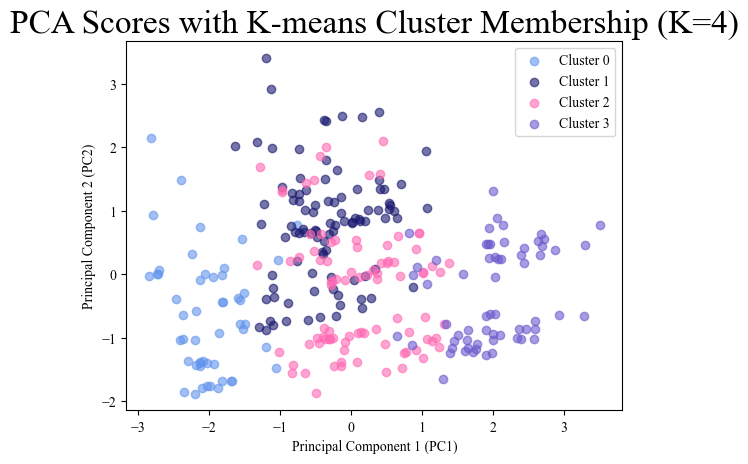

In [59]:
colors = ['cornflowerblue', 'midnightblue', 'hotpink', 'slateblue']
cluster_labels = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']

for i in range(4):
    cluster_data = pca_df[pca_df['Cluster'] == i]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], c=colors[i], label=cluster_labels[i], alpha=0.6)

plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.title('PCA Scores with K-means Cluster Membership (K=4)', fontsize=24)
plt.legend()
plt.show()

### (iv) Identify the individual with the highest score for the first principal component, and compare the features of this individual with the individual having the highest score on the second principal component.

In [63]:
# Identify individuals with highest PC1 and PC2 scores
max_pc1_idx = pca_df['PC1'].idxmax()
max_pc2_idx = pca_df['PC2'].idxmax()

max_pc1_score = pca_df.loc[max_pc1_idx, 'PC1']
max_pc2_score = pca_df.loc[max_pc2_idx, 'PC2']

In [65]:
# Extract features for these individuals
individual_max_pc1 = df_q2.iloc[max_pc1_idx]

print('Highest PC1 score')
print(individual_max_pc1)

Highest PC1 score
age              63
gender            1
income       105984
kids              0
ownHome           1
subscribe         0
Name: 167, dtype: int64


In [66]:
individual_max_pc2 = df_q2.iloc[max_pc2_idx]

print('Highest PC2 score')
print(individual_max_pc2)

Highest PC2 score
age             37
gender           1
income       69852
kids             5
ownHome          0
subscribe        1
Name: 295, dtype: int64


##### Annotate the individuals with highest PC1 and PC2

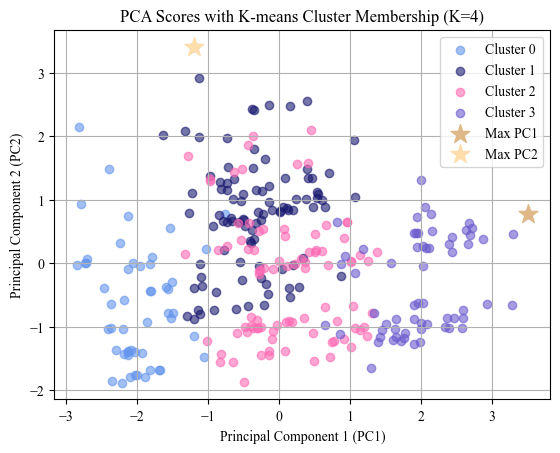

In [73]:
colors = ['cornflowerblue', 'midnightblue', 'hotpink', 'slateblue']
cluster_labels = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']

for i in range(4):
    cluster_data = pca_df[pca_df['Cluster'] == i]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], c=colors[i], label=cluster_labels[i], alpha=0.6)

plt.scatter(max_pc1_score, pca_df.loc[max_pc1_idx, 'PC2'], c='burlywood', marker='*', s=200, label='Max PC1')
plt.scatter(pca_df.loc[max_pc2_idx, 'PC1'], max_pc2_score, c='navajowhite', marker='*', s=200, label='Max PC2')

plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.title('PCA Scores with K-means Cluster Membership (K=4)')
plt.legend()
plt.grid(True)
plt.show()